# TSE(R,S) analysis for time evolving Kuramoto model

Content:
- Functions to obtain information metrics (R,S,TSE) per sliding timewindow for a given timeseries
- Example of TSE evolution for one system
- Results of TSE evolution for large number of systems

Import libraries

In [2]:
import infotopo_no_prints
import os
import xgi
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from sklearn.utils import Bunch
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

Define functions

In [3]:
# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value', 'R_std', 'S_std']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        S_std = np.std(S_values, ddof=1)
        R_std = np.std(R_values, ddof=1)
        S_sum = sum(S_values)
        R_sum = sum(R_values)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value], 'R_std': [R_std], 'S_std':[S_std]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

# Kuramoto model differential equation
def kuramoto(t, theta, omega, K, N):
    dtheta = np.zeros(N)
    for i in range(N):
        interaction = np.sum(np.sin(theta - theta[i]))
        dtheta[i] = omega[i] + (K / N) * interaction
    return dtheta

# Simulate the Kuramoto model and save frequency time series
def simulate_kuramoto(N=50, K=2.0, T=20, dt=0.01):
    # Initialize random natural frequencies and initial phases
    omega = np.random.normal(loc=0, scale=1, size=N)
    initial_phases = np.random.uniform(0, 2 * np.pi, N)
    
    # Time vector
    t_eval = np.arange(0, T, dt)
    
    # Solve the system
    sol = solve_ivp(kuramoto, [0, T], initial_phases, args=(omega, K, N), t_eval=t_eval, method='RK45')
    
    # Compute instantaneous frequencies (time derivative of phases)
    frequencies = np.gradient(sol.y, sol.t, axis=1)

    # Convert to right data format
    frequencies_df = pd.DataFrame(frequencies).transpose()
    
    return frequencies_df

# Simulate Kuramoto model for high order interactions with XGI
def simulate_kuramoto_xgi(H, K2, K3, T=20, dt=0.01):
    timesteps=int(T/dt)
    H_int = xgi.convert_labels_to_integers(H, "label")
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    n = H_int.num_nodes

    theta_time = np.zeros((timesteps, n))
    times = np.arange(timesteps) * dt

    omega = np.random.normal(0, 1, n)
    theta = np.random.random(n) * 2 * np.pi

    for t in range(timesteps):
        theta_time[t] = theta
        r1 = np.zeros(n, dtype=complex)
        r2 = np.zeros(n, dtype=complex)

        for i, j in links:
            r1[i] += np.exp(1j * theta[j])
            r1[j] += np.exp(1j * theta[i])

        for i, j, k in triangles:
            r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[j])
            r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[i])
            r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(2j * theta[j] - 1j * theta[i])

        d_theta = omega + K2 * np.multiply(r1, np.exp(-1j * theta)).imag + K3 * np.multiply(r2, np.exp(-1j * theta)).imag
        theta_new = theta + d_theta * dt
        theta = theta_new

    frequencies_df = pd.DataFrame(theta_time, index=times)

    return frequencies_df

In [4]:
# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value', 'R_std', 'S_std', 'TC_lists']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        S_std = np.std(S_values, ddof=1)
        R_std = np.std(R_values, ddof=1)
        S_sum = sum(S_values)
        R_sum = sum(R_values)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value], 'R_std': [R_std], 'S_std':[S_std], 'TC_lists':[Ninfomut]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

Merge Kuramoto models

In [5]:
# Parameters
N = 8   # Number of oscillators
K = 1.0  # Coupling strength
T = 40   # Total time
dt = 0.01  # Time step

# Construct an all-to-all pairwise hypergraph (equivalent to a complete graph)
H = xgi.Hypergraph()
H.add_nodes_from(range(N))  # Add nodes
for i in range(N):
    for j in range(i + 1, N):
        H.add_edge([i, j])  # Add all possible pairwise links

# Set k2 = K / N for consistency with the standard Kuramoto model
K2 = K / N
K3 = 0  # Higher-order interactions

# Run the simulation
frequencies_df = simulate_kuramoto_xgi(H, K2, K3, T, dt)
# frequencies_df = simulate_kuramoto(N, K, T, dt)

In [6]:
# Obtain information metrics
window_size = 1000
window_step = 10
dimension_max = 8
dimension_tot = 8

df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

C:\Users\cyril\AppData\Local\Temp\ipykernel_28844\914995518.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


In [7]:
data = df_oscillators["TC_lists"][0]

# Count occurrences of each key length
length_counts = {}

for key in data.keys():
    length = len(key)  # Get length of the tuple (key)
    length_counts[length] = length_counts.get(length, 0) + 1

# Initialize variables
cumulative_sum = 0
orders_list = []

# Iterate through dictionary values and compute cumulative sums
for value in length_counts.values():
    cumulative_sum += value  # Add current value to the cumulative sum
    orders_list.append(cumulative_sum)  # Store the cumulative sum

# Convert keys to strings and store in a list
keys_list = [str(key) for key in length_counts.keys()]


C:\Users\cyril\AppData\Local\Temp\ipykernel_28844\1256661039.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


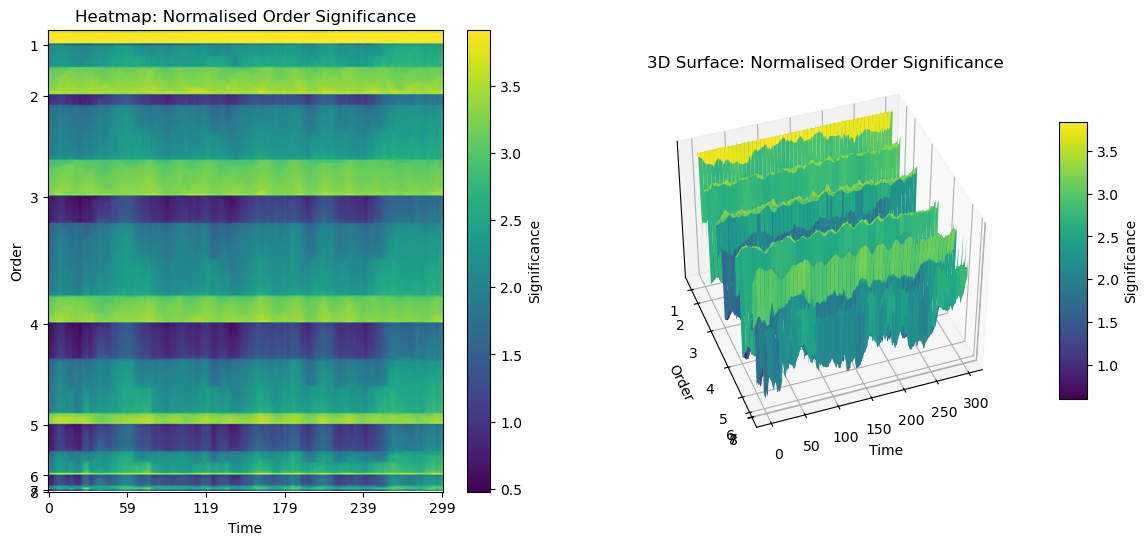

In [8]:
# Define data directly as a list of lists
data = []

for TC_dictionary in df_oscillators['TC_lists']:
    sorted_dict = dict(sorted(TC_dictionary.items(), key=lambda item: (len(item[0]), item[1])))
    data.append(list(sorted_dict.values()))

# Convert to NumPy array
data = np.array(data)

# Keep only the first part
data = data[:]

# Define time and order indices
x = np.arange(data.shape[0])  # Time steps
y = np.arange(data.shape[1])  # Order indices
X, Y = np.meshgrid(x, y, indexing="xy")  # Corrected meshgrid orientation
Z = data.T  # Transpose to align with heatmap orientation

# Create figure with two subplots (side-by-side)
fig = plt.figure(figsize=(14, 6))

### First Plot (Heatmap) ###
ax1 = fig.add_subplot(1, 2, 1)  # First subplot

cax = ax1.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')

# Add colorbar
cbar1 = fig.colorbar(cax, ax=ax1, label="Significance")

# Set x-axis (time)
ax1.set_xlabel("Time")
ax1.set_xticks(np.linspace(0, data.shape[0] - 1, 6))
ax1.set_xticklabels(np.linspace(0, data.shape[0] - 1, 6, dtype=int))

# Set y-axis (order)
ax1.set_ylabel("Order")
ax1.set_yticks(orders_list)
ax1.set_yticklabels(keys_list)
ax1.set_title("Heatmap: Normalised Order Significance")

ax1.invert_yaxis()  # Invert y-axis direction

### Second Plot (3D Surface) ###
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Second subplot

# Set the view angle
ax2.view_init(elev=40, azim=-110)

# Create surface plot
surf = ax2.plot_surface(X, Y, Z, cmap='viridis')

# Add colorbar
cbar2 = fig.colorbar(surf, ax=ax2, shrink=0.6, aspect=10, pad=0.1, label="Significance")

# Set y-axis ticks and labels
ax2.set_yticks(orders_list)
ax2.set_yticklabels(keys_list)
ax2.invert_yaxis()  # **Ensure y-axis matches heatmap**

# Labels
ax2.set_xlabel("Time")
ax2.set_ylabel("Order")
ax2.set_zticks([])  # Remove z-axis ticks
ax2.set_title("3D Surface: Normalised Order Significance")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


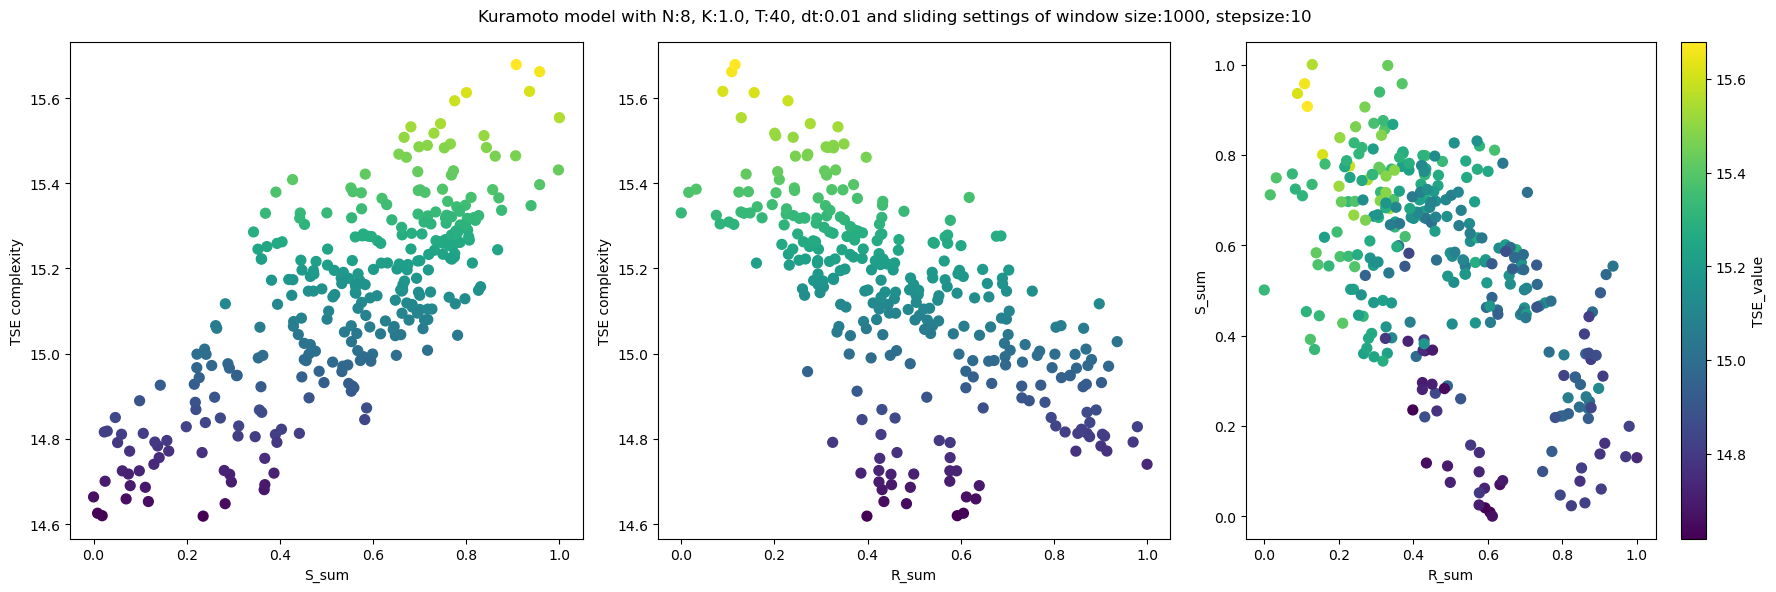

In [9]:
# Create a figure with 1 row and 3 columns for subplots
df = df_oscillators
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)
plt.scatter(df['S_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
# for i, (x, y) in enumerate(zip(df['S_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['TSE_value']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
#for i, (x, y) in enumerate(zip(df['R_sum'], df['S_sum']), 1):
#    plt.text(x, y, f'c{i}', fontsize=12, ha='right')
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()


Generate new data (OVERWRITES PREVIOUS DATA)

In [132]:
# Parameters
N = 8   # Number of oscillators
K = 3.0  # Coupling strength
T = 20   # Total time
dt = 0.01  # Time step
timesteps = int(T / dt)  # Number of time steps

# Set k2 = K / N for consistency with the standard Kuramoto model
k2 = K / N
k3 = 0  # No higher-order interactions

In [135]:
# Initialize an empty list to store dataframes
all_dfs = []

for i in range(n_simulations):
    print(f"Running simulation {i+1}/{n_simulations}...")

    # Generate Kuramoto timeseries
    # Construct an all-to-all pairwise hypergraph (equivalent to a complete graph)
    H = xgi.Hypergraph()
    H.add_nodes_from(range(N))  # Add nodes
    for i in range(N):
        for j in range(i + 1, N):
            H.add_edge([i, j])  # Add all possible pairwise links

    # Run the simulation
    frequencies_df = simulate_kuramoto_xgi(H, k2, k3, timesteps=timesteps, dt=dt)

    # Obtain information metrics
    df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max=4, dimension_tot=8)

    # Add a column to track which run the data came from
    df_oscillators['Run'] = i + 1

    # Store the dataframe in the list
    all_dfs.append(df_oscillators)

# Example of saving all DataFrames in the list as separate CSVs (optional)
for idx, df in enumerate(all_dfs):
    df.to_csv(f"Data\\Kuramoto_xgi\\df_oscillators_run_{idx+1}.csv", index=False)

Running simulation 1/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 2/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 3/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 4/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 5/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 6/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 7/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 8/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 9/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 10/10...


C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\1741877806.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


In [6]:
# Set initial conditions and settings
N=8 # number of oscillators
K2=3 # coupling strength for links
K3=0 # coupling strength for triangles
T=20 # time of simulation
dt=0.01 # timestep of simulation

window_size=1000 # size of sliding window for statistical inference
window_step=10 # stepsize of the sliding window per iteration
dimension_max=4 # maximum dimension to analyse
dimension_tot=N # total variables to consider

n_simulations=10 # number of simulations

In [102]:
# Initialize an empty list to store dataframes
all_dfs = []

for i in range(n_simulations):
    print(f"Running simulation {i+1}/{n_simulations}...")

    # Generate Kuramoto timeseries
    # frequencies_df = simulate_kuramoto(N, K2, T, dt)
    frequencies_df = simulate_kuramoto_xgi(N, K2, K3, T, dt)

    # Obtain information metrics
    df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max=4, dimension_tot=8)

    # Add a column to track which run the data came from
    df_oscillators['Run'] = i + 1

    # Store the dataframe in the list
    all_dfs.append(df_oscillators)

# Example of saving all DataFrames in the list as separate CSVs (optional)
for idx, df in enumerate(all_dfs):
    df.to_csv(f"Data\\Kuramoto_xgi\\df_oscillators_run_{idx+1}.csv", index=False)

Running simulation 1/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 2/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 3/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 4/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 5/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 6/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 7/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 8/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 9/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Running simulation 10/10...


C:\Users\cyril\AppData\Roaming\Python\Python312\site-packages\xgi\generators\random.py:154: UserWarning: This method is much slower than fast_random_hypergraph
  warn("This method is much slower than fast_random_hypergraph")
C:\Users\cyril\AppData\Local\Temp\ipykernel_8732\4247262131.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Import present data

In [10]:
# Set directory
file_list = glob.glob("Data\\Kuramoto_xgi\\df_oscillators_run_*.csv")

# Sort files to ensure they are loaded in the correct order
file_list.sort()  

# Initialize an empty list to store the imported DataFrames
all_dfs = []

# Loop through each file and read it into a DataFrame
for file in file_list:
    df = pd.read_csv(file)
    all_dfs.append(df)

Plot TSE structure and standard deviations

C:\Users\cyril\AppData\Local\Temp\ipykernel_15884\822682682.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


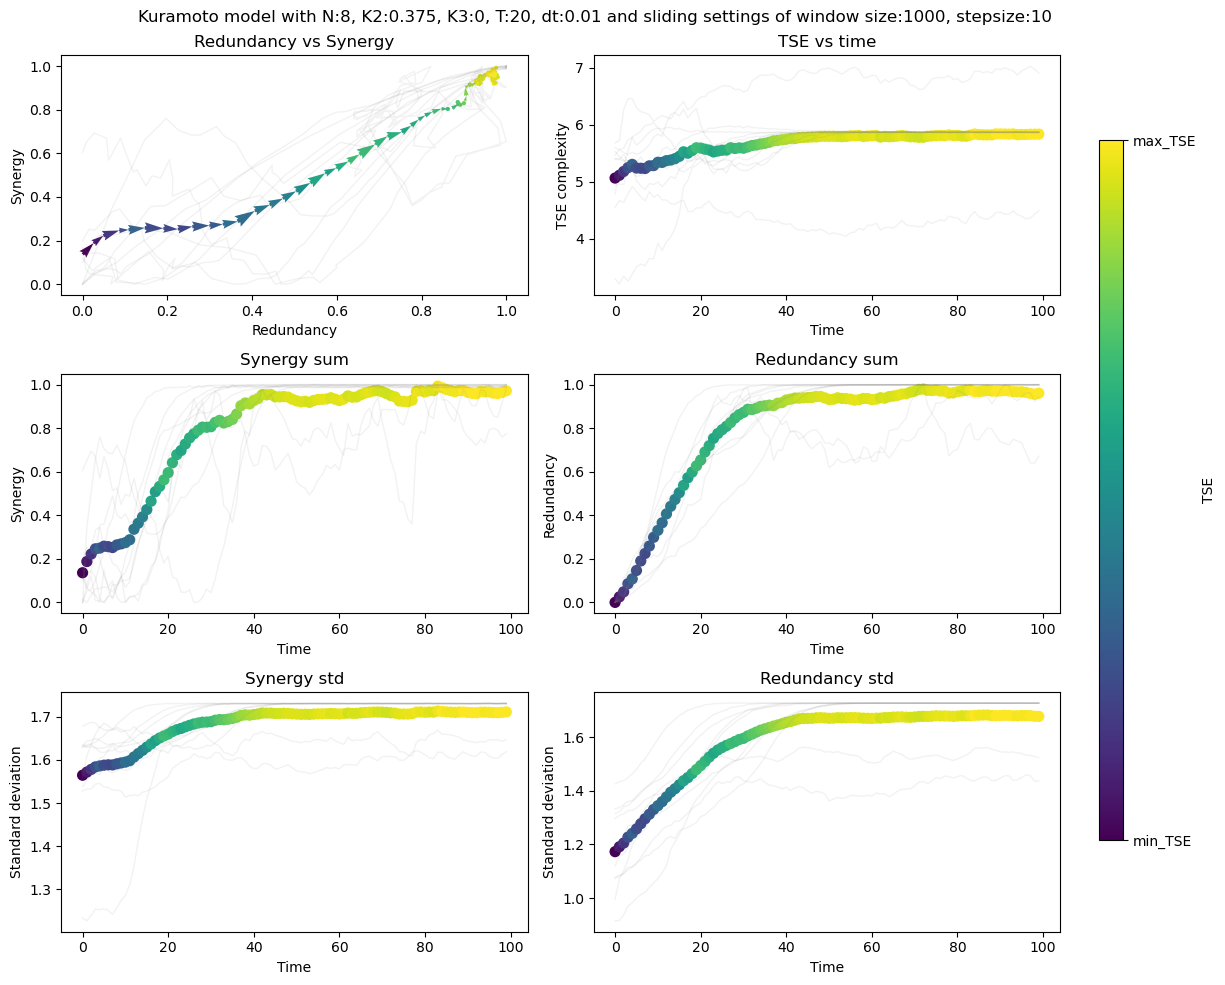

In [11]:
# Create a 2x2 figure for subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Compute the average of the simulations
df_averaged = sum(all_dfs) / len(all_dfs)
df = df_averaged

# Extract data
x1, y1, c1 = df['S_std'], df.index, df['TSE_value']
x2, y2, c2 = df['R_std'], df.index, df['TSE_value']
x3, y3, c3 = df['R_sum'], df['S_sum'], df['TSE_value']
x4, y4, c4 = df['S_sum'], df.index, df['TSE_value']
x5, y5, c5 = df['R_sum'], df.index, df['TSE_value']

# Compute arrow directions (differences between consecutive points)
dx3, dy3 = np.diff(x3), np.diff(y3)

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=df['TSE_value'].min(), vmax=df['TSE_value'].max())
cmap = plt.cm.viridis

# First subplot (Redundancy vs Synergy path)
ax1 = axes[0, 0]
for df in all_dfs:
    ax1.plot(df['R_sum'], df['S_sum'], color='grey', linewidth=1, alpha=0.1)
q3 = ax1.quiver(x3[:-1], y3[:-1], dx3, dy3, c3[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.01, alpha=1)
ax1.set_xlabel('Redundancy')
ax1.set_ylabel('Synergy')
ax1.set_title('Redundancy vs Synergy')

# Second subplot (TSE vs time)
ax2 = axes[0, 1]
for df in all_dfs:
    ax2.plot(df.index, df['TSE_value'], color='grey', linewidth=1, alpha=0.1)
ax2.scatter(df.index, c3, c=c3, cmap=cmap, norm=norm, s=50)
ax2.set_xlabel('Time')
ax2.set_ylabel('TSE complexity')
ax2.set_title('TSE vs time')

# Third subplot (Synergy std vs time)
ax3 = axes[1, 0]
for df in all_dfs:
    ax3.plot(df.index, df['S_sum'], color='grey', linewidth=1, alpha=0.1)
ax3.scatter(y4, x4, c=c4, cmap=cmap, norm=norm, s=50)
ax3.set_xlabel('Time')
ax3.set_ylabel('Synergy')
ax3.set_title('Synergy sum')

# Fourth subplot (Redundancy std vs time)
ax4 = axes[1, 1]
for df in all_dfs:
    ax4.plot(df.index, df['R_sum'], color='grey', linewidth=1, alpha=0.1)
ax4.scatter(y5, x5, c=c5, cmap=cmap, norm=norm, s=50)
ax4.set_xlabel('Time')
ax4.set_ylabel('Redundancy')
ax4.set_title('Redundancy sum')

# Third subplot (Synergy std vs time)
ax3 = axes[2, 0]
for df in all_dfs:
    ax3.plot(df.index, df['S_std'], color='grey', linewidth=1, alpha=0.1)
ax3.scatter(y1, x1, c=c1, cmap=cmap, norm=norm, s=50)
ax3.set_xlabel('Time')
ax3.set_ylabel('Standard deviation')
ax3.set_title('Synergy std')

# Fourth subplot (Redundancy std vs time)
ax4 = axes[2, 1]
for df in all_dfs:
    ax4.plot(df.index, df['R_std'], color='grey', linewidth=1, alpha=0.1)
ax4.scatter(y2, x2, c=c2, cmap=cmap, norm=norm, s=50)
ax4.set_xlabel('Time')
ax4.set_ylabel('Standard deviation')
ax4.set_title('Redundancy std')

# Add a single colorbar for all subplots, placed beside the right column
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label('TSE')

# Modify the colorbar labels to 'min_TSE' and 'max_TSE'
min_TSE = c3.min()
max_TSE = c3.max()
cbar.set_ticks([min_TSE, max_TSE])
cbar.set_ticklabels(['min_TSE', 'max_TSE'])

# Adjust layout to avoid overlap
plt.suptitle(f'Kuramoto model with N:{N}, K2:{K2}, K3:{K3}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

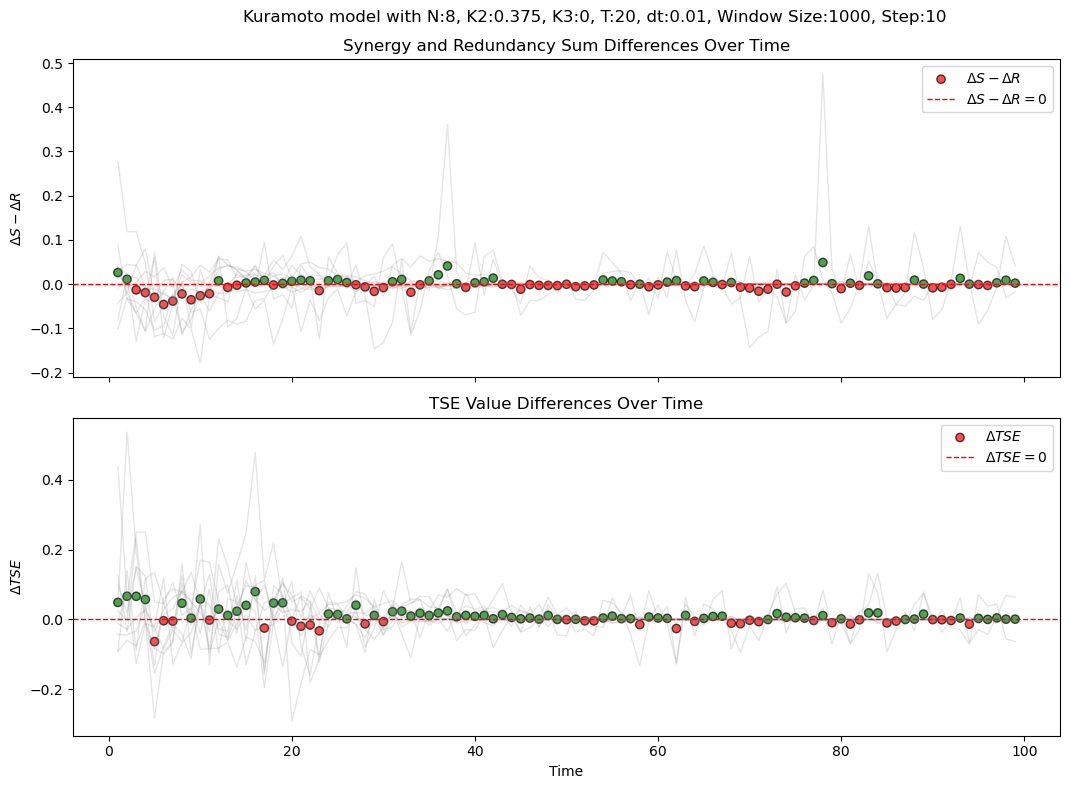

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# Create a single figure with 2 vertically stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)  # Slightly larger for better readability

# Compute the average of the simulations
df_averaged = sum(all_dfs) / len(all_dfs)
df = df_averaged

# Extract relevant data for first plot
synergy_diff = df['S_sum'].diff()
redundancy_diff = df['R_sum'].diff()
diff_values_1 = synergy_diff - redundancy_diff
time = df.index
tse_values = df['TSE_value']

# Extract relevant data for second plot
diff_values_2 = df['TSE_value'].diff()

# Assign colors: Green for positive values, Red for negative values
scatter_colors_1 = np.where(diff_values_1 > 0, 'green', 'red')
scatter_colors_2 = np.where(diff_values_2 > 0, 'green', 'red')

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=tse_values.min(), vmax=tse_values.max())
cmap = plt.cm.viridis

### **First Plot (Synergy - Redundancy Difference Over Time)**
ax1 = axes[0]
for df in all_dfs:
    ax1.plot(df.index, df['S_sum'].diff() - df['R_sum'].diff(), color='grey', linewidth=1, alpha=0.2)

ax1.scatter(time, diff_values_1, c=scatter_colors_1, edgecolors='black', label=r'$\Delta S - \Delta R$', alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, label=r'$\Delta S - \Delta R = 0$')

# Labels and title
ax1.set_ylabel(r'$\Delta S - \Delta R$')
ax1.set_title('Synergy and Redundancy Sum Differences Over Time')
ax1.legend()

### **Second Plot (TSE Difference Over Time)**
ax2 = axes[1]
for df in all_dfs:
    ax2.plot(df.index, df['TSE_value'].diff(), color='grey', linewidth=1, alpha=0.2)

ax2.scatter(time, diff_values_2, c=scatter_colors_2, edgecolors='black', label=r'$\Delta TSE$', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, label=r'$\Delta TSE = 0$')

# Labels and title
ax2.set_xlabel('Time')
ax2.set_ylabel(r'$\Delta TSE$')
ax2.set_title('TSE Value Differences Over Time')
ax2.legend()

# Adjust layout
plt.suptitle(f'Kuramoto model with N:{N}, K2:{K2}, K3:{K3}, T:{T}, dt:{dt}, Window Size:{window_size}, Step:{window_step}')
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Show the plot
plt.show()


Plot average synergy and redundancy paths

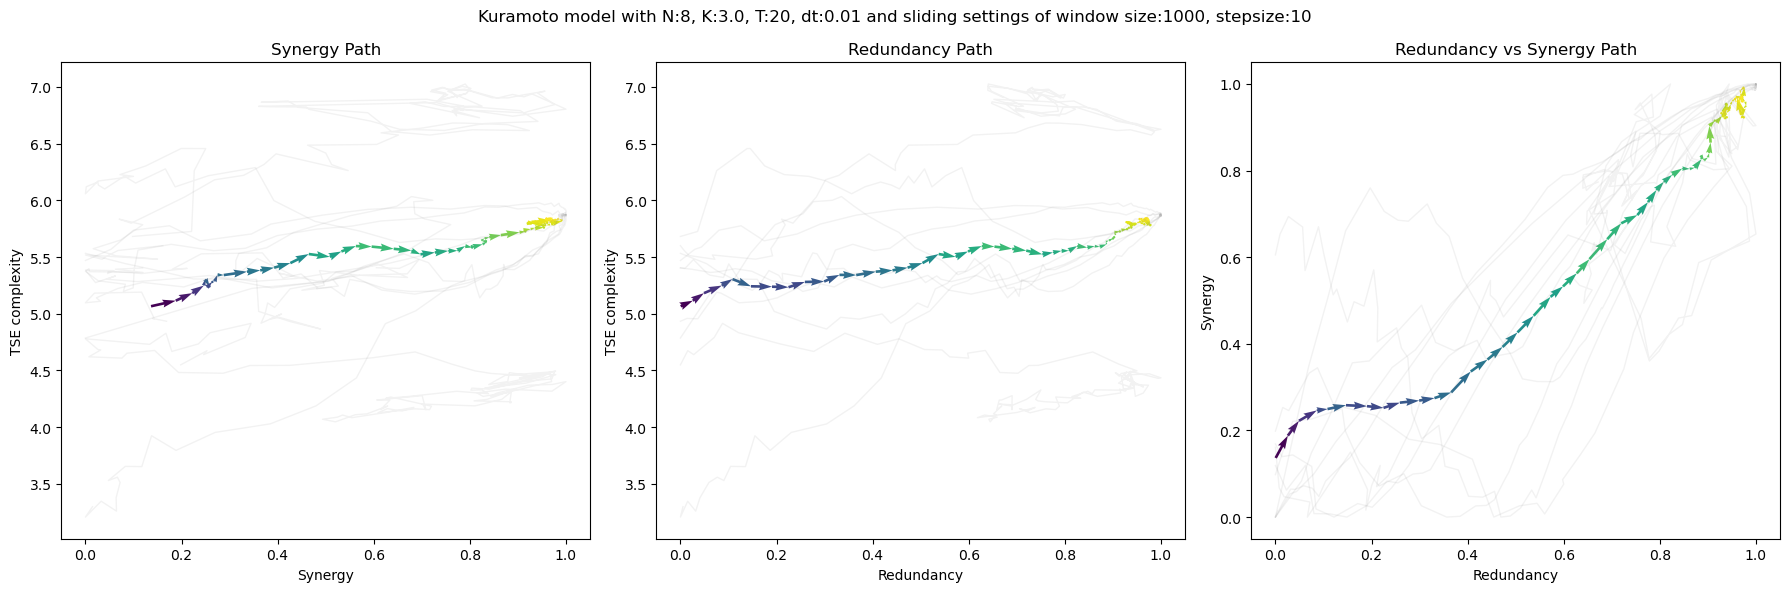

In [13]:
# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Compute the average of the simulations
df_averaged = sum(all_dfs) / len(all_dfs)
df = df_averaged

# Extract data
x1, y1, c1 = df['S_sum'], df['TSE_value'], df['TSE_value']
x2, y2, c2 = df['R_sum'], df['TSE_value'], df['TSE_value']
x3, y3, c3 = df['R_sum'], df['S_sum'], df['TSE_value']

# Compute arrow directions (differences between consecutive points)
dx1, dy1 = np.diff(x1), np.diff(y1)
dx2, dy2 = np.diff(x2), np.diff(y2)
dx3, dy3 = np.diff(x3), np.diff(y3)

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=df['TSE_value'].min(), vmax=df['TSE_value'].max())
cmap = plt.cm.viridis

# First subplot for Synergy path
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    axes[0].plot(df['S_sum'], df['TSE_value'], color='grey', linewidth=1, alpha=0.1)
q1 = axes[0].quiver(x1[:-1], y1[:-1], dx1, dy1, c1[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005, alpha=1)
axes[0].set_xlabel('Synergy')
axes[0].set_ylabel('TSE complexity')
axes[0].set_title('Synergy Path')

# Second subplot for Redundancy path
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    axes[1].plot(df['R_sum'], df['TSE_value'], color='grey', linewidth=1, alpha=0.1)
q2 = axes[1].quiver(x2[:-1], y2[:-1], dx2, dy2, c2[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005, alpha=1)
axes[1].set_xlabel('Redundancy')
axes[1].set_ylabel('TSE complexity')
axes[1].set_title('Redundancy Path')

# Third subplot for Redundancy vs Synergy path
for df in all_dfs:
    # First subplot for Synergy path (S_sum vs TSE_value)
    axes[2].plot(df['R_sum'], df['S_sum'], color='grey', linewidth=1, alpha=0.1)
q3 = axes[2].quiver(x3[:-1], y3[:-1], dx3, dy3, c3[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.005, alpha=1)
axes[2].set_xlabel('Redundancy')
axes[2].set_ylabel('Synergy')
axes[2].set_title('Redundancy vs Synergy Path')

# Add a single colorbar for all subplots
# cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
# cbar.set_label('TSE_value')

# Adjust layout to avoid overlap and display the plot
plt.suptitle(f'Kuramoto model with N:{N}, K:{K}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout()
plt.show()


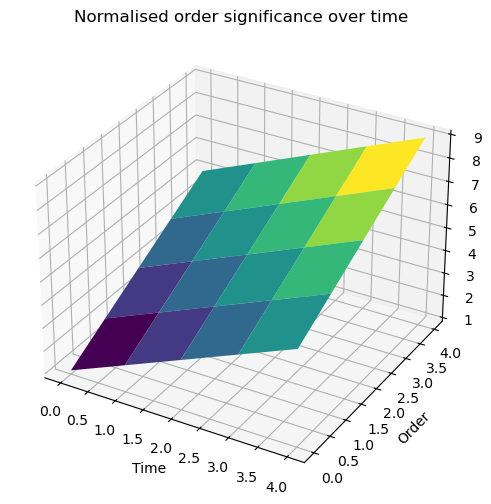

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define data directly as a list of lists
data = [
    [1, 2, 3, 4, 5],
    [2, 3, 4, 5, 6],
    [3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8],
    [5, 6, 7, 8, 9]
]

# Convert to NumPy array for easier manipulation
data = np.array(data)  

# Define X and Y grid based on indices
x = np.arange(data.shape[0])  # Row indices (time)
y = np.arange(data.shape[1])  # Column indices (order)
X, Y = np.meshgrid(x, y, indexing="ij")  # Create meshgrid

# Z values (actual values from the list of lists)
Z = data

# Plot the surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Order")
ax.set_zlabel("Significance")
ax.set_title("Normalised order significance over time")

plt.show()
